In [3]:
!pip install pmdarima


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 2.4 MB/s eta 0:00:06
    --------------------------------------- 0.2/13.3 MB 1.8 MB/s eta 0:00:08
    --------------------------------------- 0.3/13.3 MB 1.7 MB/s eta 0:00:08
   - -------------------------------------- 0.4/13.3 MB 1.7 MB/s eta 0:00:08
   - -------------------------------------- 0.5/13.3 MB 1.8 MB/s eta 0:00:08
   - -------------------------------------- 0.7/13.3 MB 1.8 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/13.3 MB 1.7 MB/s eta 0:00:08
   -- ------------------------------------- 0.9/13.3 MB 1.7 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/13.3 MB 1.8 MB/s eta 0:00:07
   --- ------------------------------------ 1.1/13.3 MB 1.8 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/13.3 MB 1.8 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/13.3 MB 1.7 MB/s eta 0:00:07
   ---


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [7]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *

In [8]:
df = pd.read_csv("walmart_cleaned.csv")
df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [9]:
# 주별 집계 데이터 테이블을 만들기!

# Date 칼럼을 시계열데이터인 Date2 칼럼으로 만들기
df['Date2']= pd.to_datetime(df['Date'])

#날짜 정렬하기
df = df.sort_values(by='Date2')

#연도 컬럼 추출하기
df['year'] = df['Date2'].dt.year # 시계열 데이터인 경우는 dt.year, month 요일 별 값을 추출 가능

# 집계 컬럼만들기

def func(df):
    df_sum={}
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    df_sum['Temperature'] = df['Temperature'].mean()
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    df_sum['CPI'] = df['CPI'].mean()
    df_sum['Unemployment'] = df['Unemployment'].mean()
    return pd.Series(df_sum, index=['Weekly_Sales','Temperature','Fuel_Price','IsHoliday','CPI','Unemployment'])


df_agg = df.groupby(['year','Date2']).apply(func).reset_index()

df_agg

,year,Date2,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment
0,2010,2010-02-05,49750740.50,33.277942,2.717869,0.0,167.398405,8.576731
1,2010,2010-02-12,48336677.63,33.361810,2.696102,1.0,167.384138,8.567309
2,2010,2010-02-19,48276993.78,37.038310,2.673666,0.0,167.338966,8.576351
3,2010,2010-02-26,43968571.13,38.629563,2.685642,0.0,167.691019,8.561375
4,2010,2010-03-05,46871470.30,42.373998,2.731816,0.0,167.727351,8.572689
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,0.0,175.919639,7.225855
139,2012,2012-10-05,47566639.31,65.456811,3.848435,0.0,175.998254,6.942141
140,2012,2012-10-12,46128514.25,57.687284,3.897425,0.0,176.123786,6.952682
141,2012,2012-10-19,45122410.57,60.152756,3.878413,0.0,176.295499,6.948928


Text(0.5, 1.0, 'Weekly Sales')

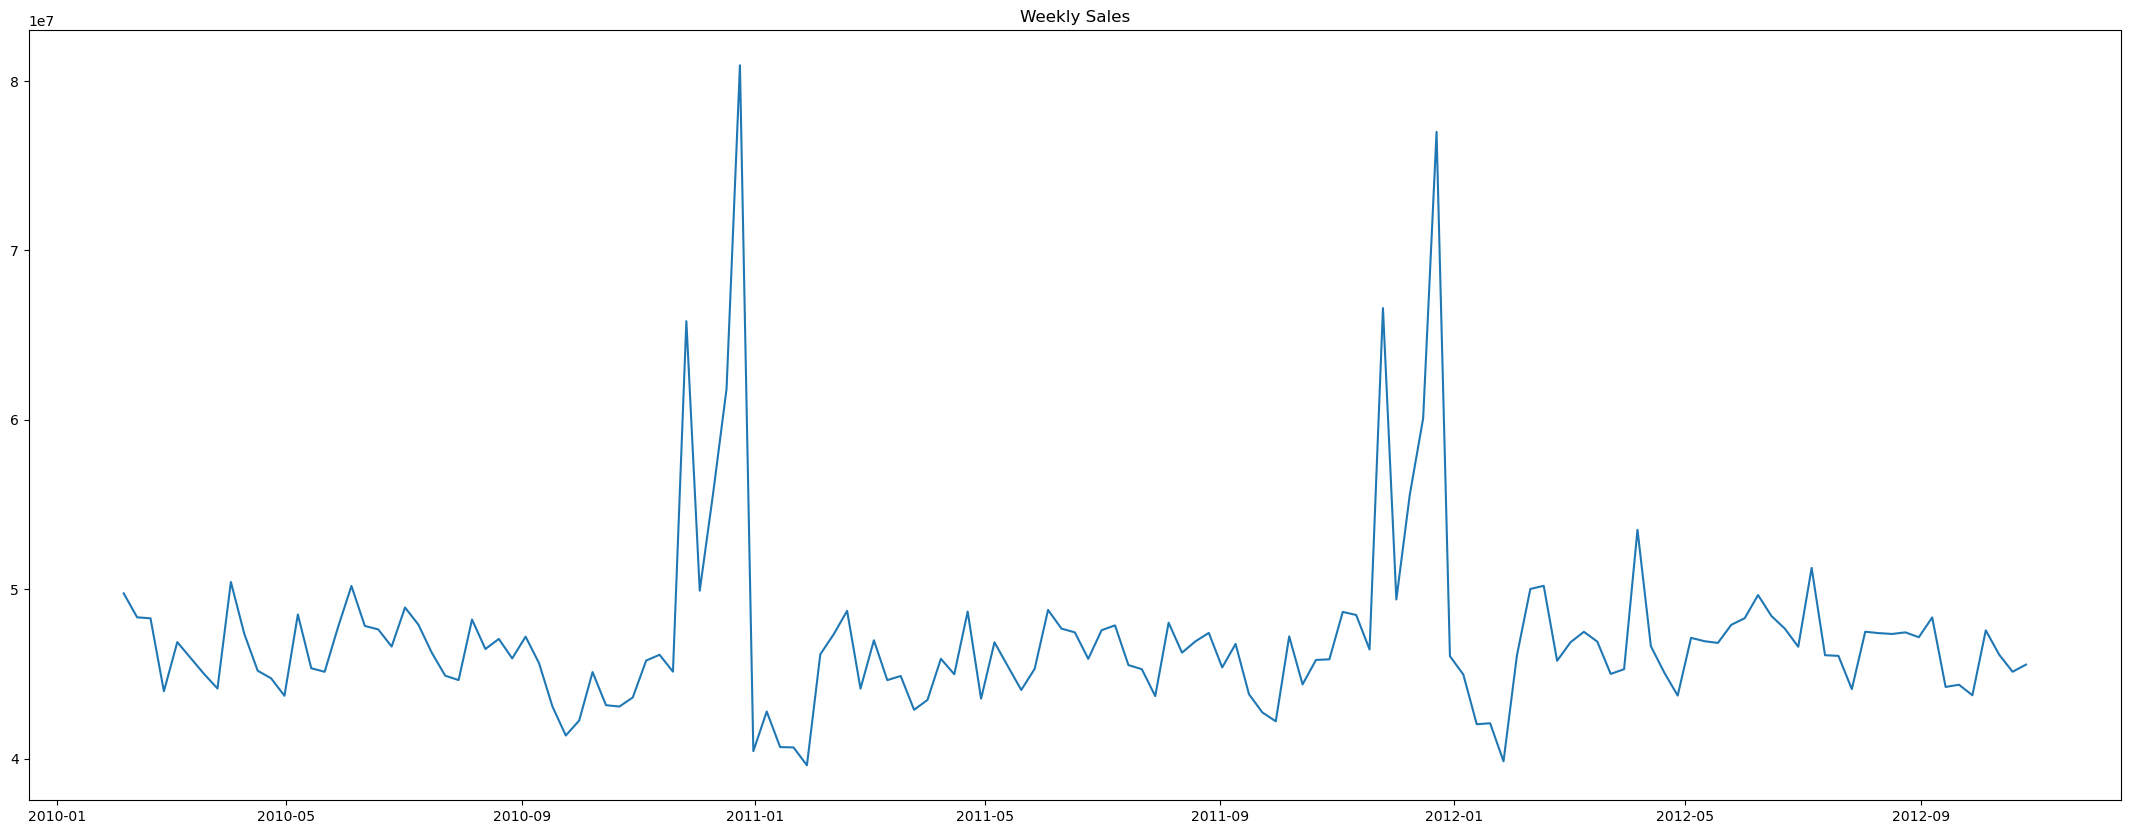

In [10]:
# 변수의 추세나 변동

plt.figure(figsize=(27,10))
plt.plot(df_agg.Date2, df_agg.Weekly_Sales)
plt.title('Weekly Sales')

In [11]:
#decomp 분해하기

# Date2와 Weekly_Sales만 추출한 후 Date2를 인덱스로 설정
timeseries_decomp = df_agg.loc[:, ['Date2','Weekly_Sales']]
timeseries_decomp.index = timeseries_decomp.Date2
ts_decomp = timeseries_decomp.drop('Date2',axis=1)

ts_decomp

,Weekly_Sales
Date2,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


<Figure size 640x480 with 0 Axes>

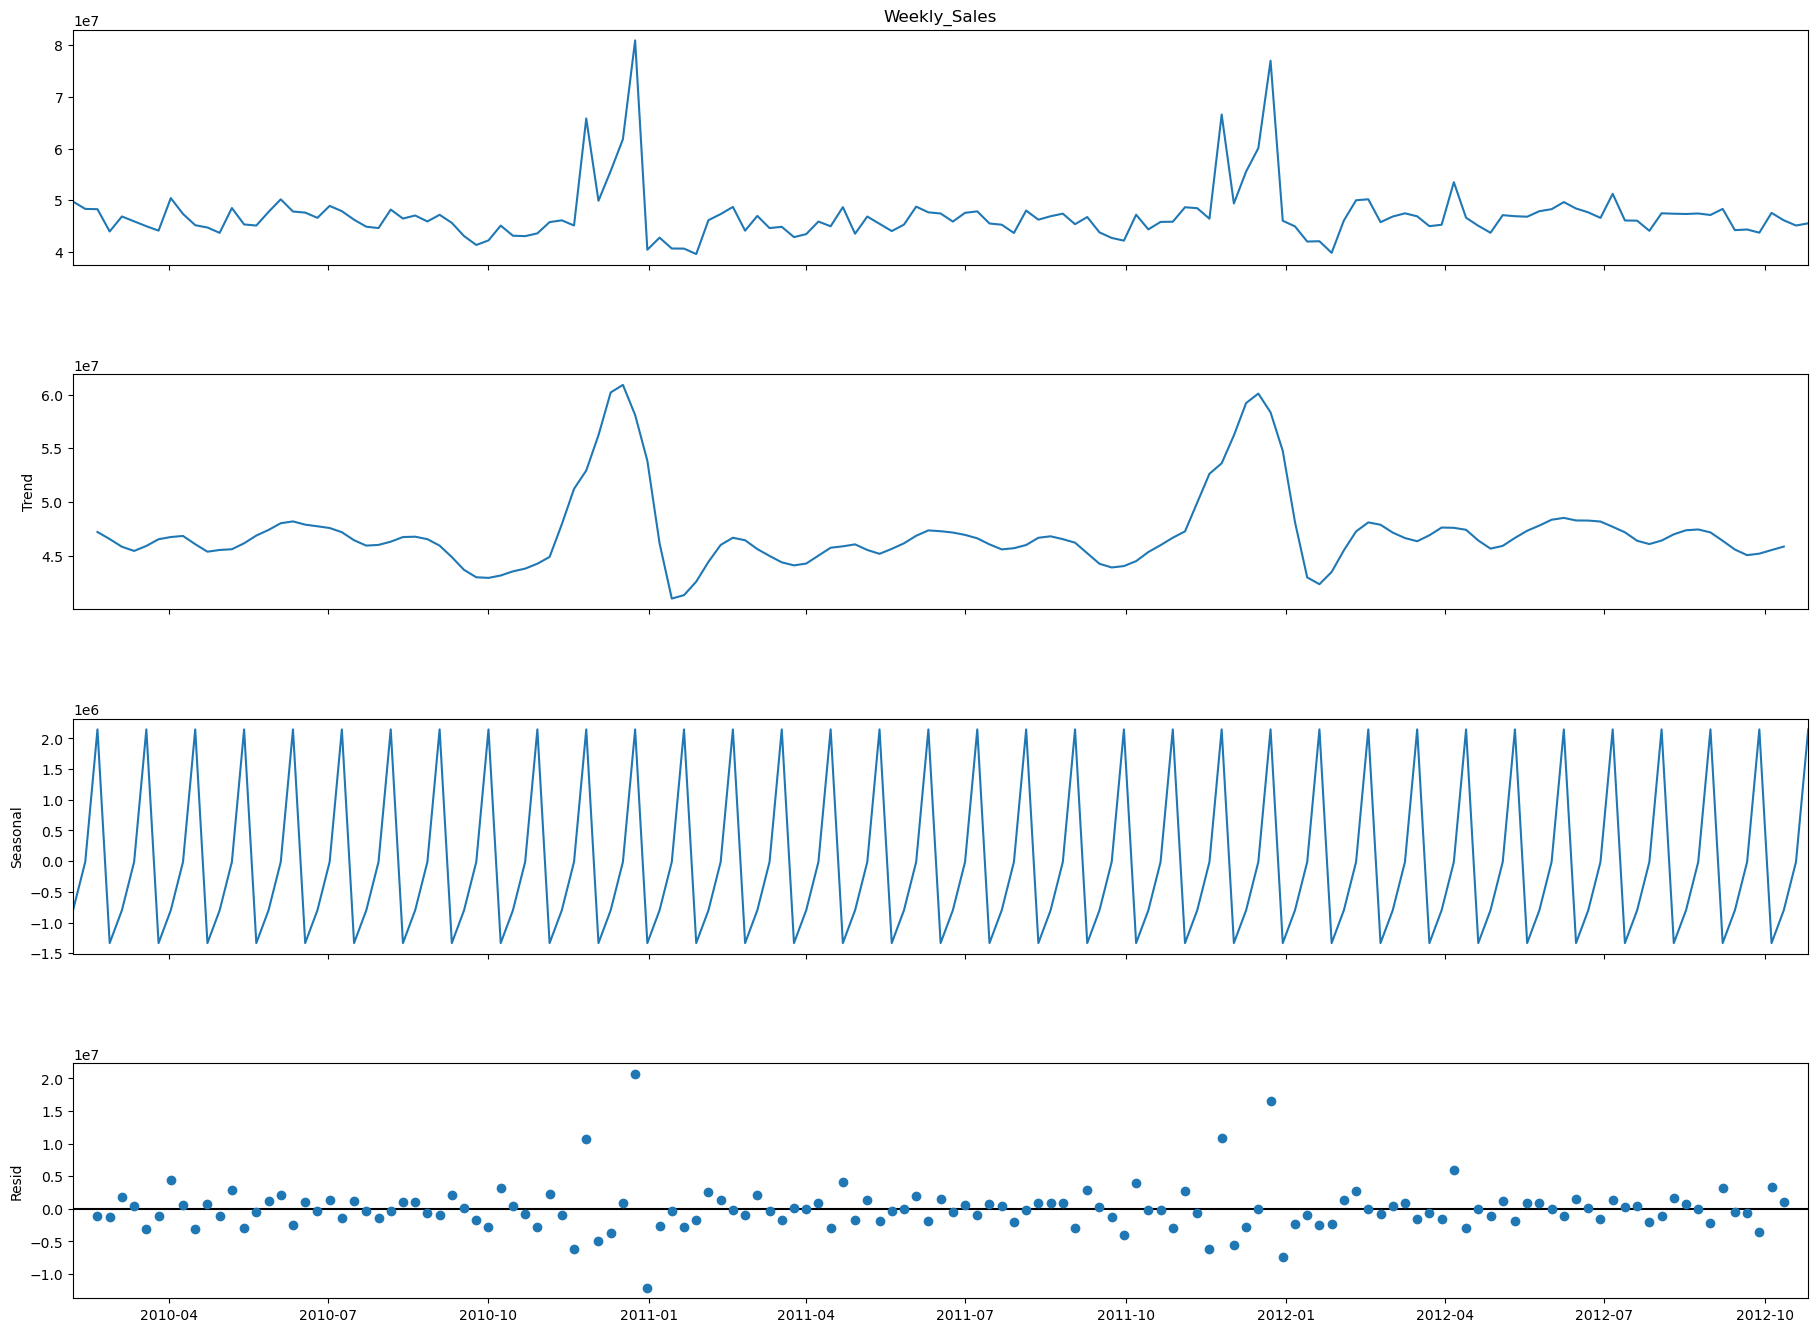

In [12]:
#시계열로 분해하기
# seasonal_decompose : 패턴을 확인
# 월별(12), 주별(4), 일별(7)로 패턴을 볼 수 있음

decomp = seasonal_decompose(ts_decomp['Weekly_Sales'], model= 'additive', period = 4)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(20,15)
plt.show()

# ACF, PACF 함수 그래프 그리기

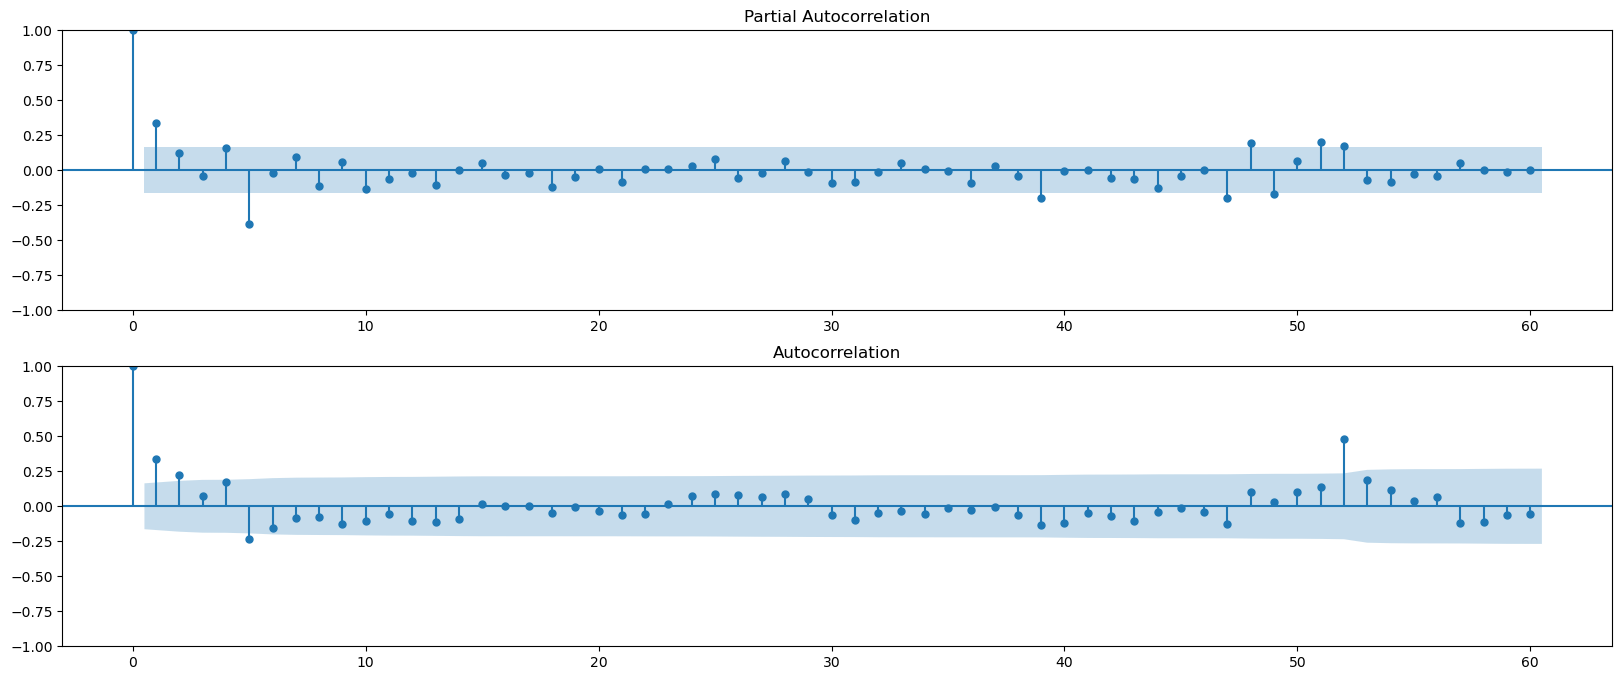

In [13]:
fig =plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(ts_decomp, lags=60, ax=ax1)

ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(ts_decomp, lags=60, ax=ax2)

## 1. 회귀분석을 통한 예측

In [14]:
# shift(n) : n주 전의 값으로 이동 -> 주기성, 특정 기가에 대한 변화 탐색
df_agg['Weekly_Sales_1w']= df_agg['Weekly_Sales'].shift(1)
df_agg['Weekly_Sales_2w']=df_agg['Weekly_Sales'].shift(2)
df_agg['Weekly_Sales_3w']=df_agg['Weekly_Sales'].shift(3)
df_agg['Weekly_Sales_4w']=df_agg['Weekly_Sales'].shift(4)
df_agg['Weekly_Sales_52w']=df_agg['Weekly_Sales'].shift(52)


#모델의 학습을 하기 위해서 데이터 기간을 설정!
df_agg[df_agg['Date2'].isin(pd.date_range('2011-02-05', '2012-10-26'))]

# x와 y 독립변수와 종속변수 분리
df_x = df_agg.drop(['year','Date2','Weekly_Sales'],axis=1)
df_y = df_agg[['Weekly_Sales']]

# 테스트 데이터 트레인데이터 분리
df_x =df_x.fillna(0)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.6, random_state=1)

In [15]:
#다중 회귀 모델 학습
# y절편과 기울기를 함께 학습
mreg = LinearRegression(fit_intercept=True)
mreg.fit(x_train, y_train)

# 테스트셋 모델 적용
y_predict = mreg.predict(x_test)

#모델 성능 확인
print('학습 데이터 R-Squarue {:.5f}'.format(mreg.score(x_train, y_train)))
print('테스트 데이터 R-Squarue {:.5f}'.format(mreg.score(x_test, y_test)))

학습 데이터 R-Squarue 0.37937
테스트 데이터 R-Squarue -0.03778


- df_x의 결측치를 0으로 채워넣었기 때문에 문제 발생

In [16]:
#모델 상세 확인

ols_m = sm.OLS(y_train, sm.add_constant(x_train)).fit()
ols_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     2.812
Date:                Sun, 21 Jan 2024   Prob (F-statistic):            0.00833
Time:                        02:03:57   Log-Likelihood:                -912.83
No. Observations:                  57   AIC:                             1848.
Df Residuals:                      46   BIC:                             1870.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.548e+08   1.73e+08      0.895      0.376   -1.94e+08    5.03e+08
Temperature       3.064e+04   2.17e+04      1.412      0.165    -1.3e+04    7.43e+04
Fuel_Price        -6.13e+06   2.19e+06     -2.800      0.007   -1.05e+07   -1.72e+06
IsHoliday        -2.683e+05   1.63e+06     -0.165      0.870   -3.54e+06       3e+06
CPI              -3.749e+05   8.26e+05     -0.454      0.652   -2.04e+06    1.29e+06
Unemployment     -3.243e+06   4.39e+06     -0.739      0.464   -1.21e+07    5.59e+06
Weekly_Sales_1w      0.0258      0.057      0.452      0.653      -0.089       0.141
Weekly_Sales_2w      0.0593      0.058      1.020      0.313      -0.058       0.176
Weekly_Sales_3w     -0.1448      0.048     -3.004      0.004      -0.242      -0.048
Weekly_Sales_4w     -0.0072      0.041     -0.174      0.862      -0.091       0.076
Weekly_Sales_52w     0.1133      0.041      2.747      0.009       0.030       0.196
==============================================================================
Omnibus:                        1.549   Durbin-Watson:                   2.497
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.362
Skew:                           0.372   Prob(JB):                        0.506
Kurtosis:                       2.860   Cond. No.                     5.25e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2. ARIMA

In [17]:
def ADF(ts_decomp):
    result = adfuller(ts_decomp.values, autolag='AIC')
    print('TEST 진행')
    print('ADF Statistics 값 %f' % result[0])
    print('p-value 값 %f' %result[1])
    print('Lag 값 %f' %result[2])
    print('관측 값 %f' %result[3])
    print('기각역')
    for key, values in result[4].items():
        print('t%s: %.3f' % (key,values))
        
ADF(ts_decomp)

TEST 진행
ADF Statistics 값 -5.908298
p-value 값 0.000000
Lag 값 4.000000
관측 값 138.000000
기각역
t1%: -3.479
t5%: -2.883
t10%: -2.578


- 시계열의 정상성을 판단하기 위해 ADF 진행

In [18]:
# Arima를 위한 학습셋, 테스트셋 나누기
train = ts_decomp.loc['2010-02-05':'2012-09-21']
test = ts_decomp.loc['2012-09-28':'2012-10-26']

In [19]:
# p,d,q 값을 파라미터 설정
p,d,q = 2,0,2

model_arima = ARIMA(train['Weekly_Sales'], order=(p,d,q))
model_arima_fit = model_arima.fit()

In [20]:
#결과값 예측하기

pred1 = model_arima_fit.forecast(steps=5)[0]
pred1 = pd.Series(pred1, index= test.index)

print(np.round_(pred1,2))

Date2
2012-09-28    46540958.83
2012-10-05    46540958.83
2012-10-12    46540958.83
2012-10-19    46540958.83
2012-10-26    46540958.83
dtype: float64


<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

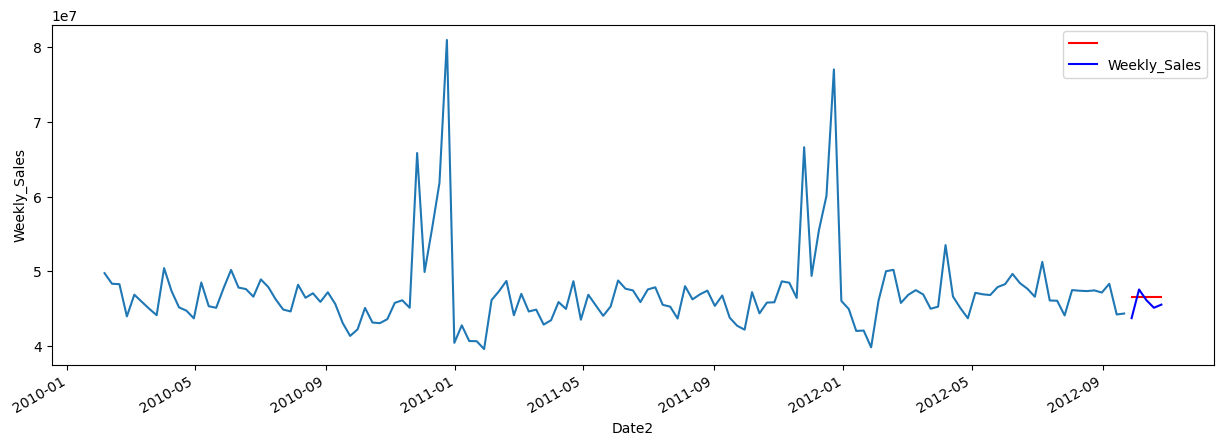

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date2', y='Weekly_Sales', data= train)
pred1.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

<Axes: xlabel='Date2', ylabel='Weekly_Sales'>

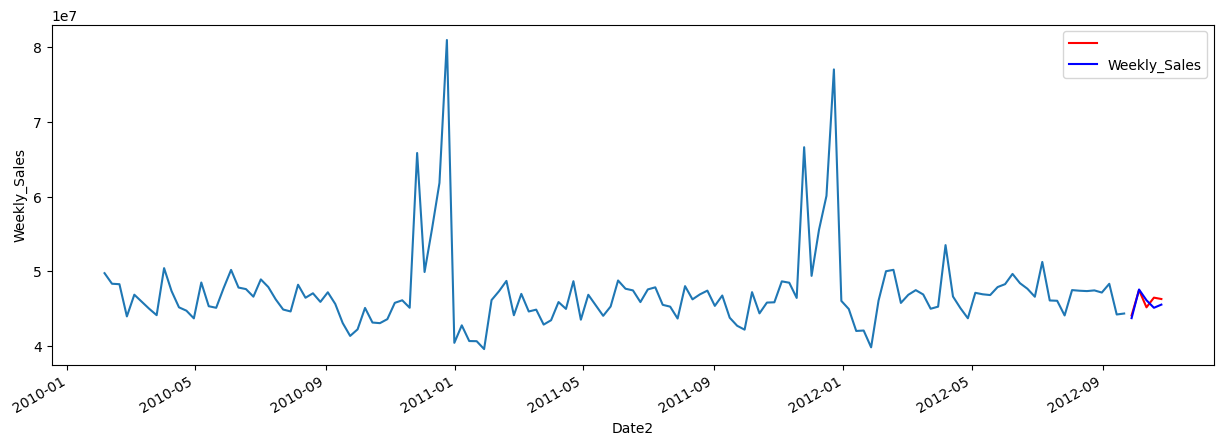

In [22]:
# Auto - Arima

auto_arima_model = pm.auto_arima(train, seasonal=True, m = 52)

pred2= auto_arima_model.predict(5)
pred2 = pd.Series(pred2, index= test.index)

#auto-ARIMA 학습 시각화
fig, ax = plt.subplots(figsize=(15,5))
graph = sns.lineplot(x ='Date2', y='Weekly_Sales', data= train)
pred2.plot(ax=ax ,color='red', legend=True)
test.plot(ax=ax, color='blue', legend=True)

In [23]:
# auto_arima 모델요약
print(auto_arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  138
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2296.614
Date:                             Sun, 21 Jan 2024   AIC                           4607.228
Time:                                     02:10:50   BIC                           4627.719
Sample:                                 02-05-2010   HQIC                          4615.555
                                      - 09-21-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.115e+07    1.7e-08   1.83e+15      0.000    3.12e+07    3.12e+07
ar.L1         -0.8130      

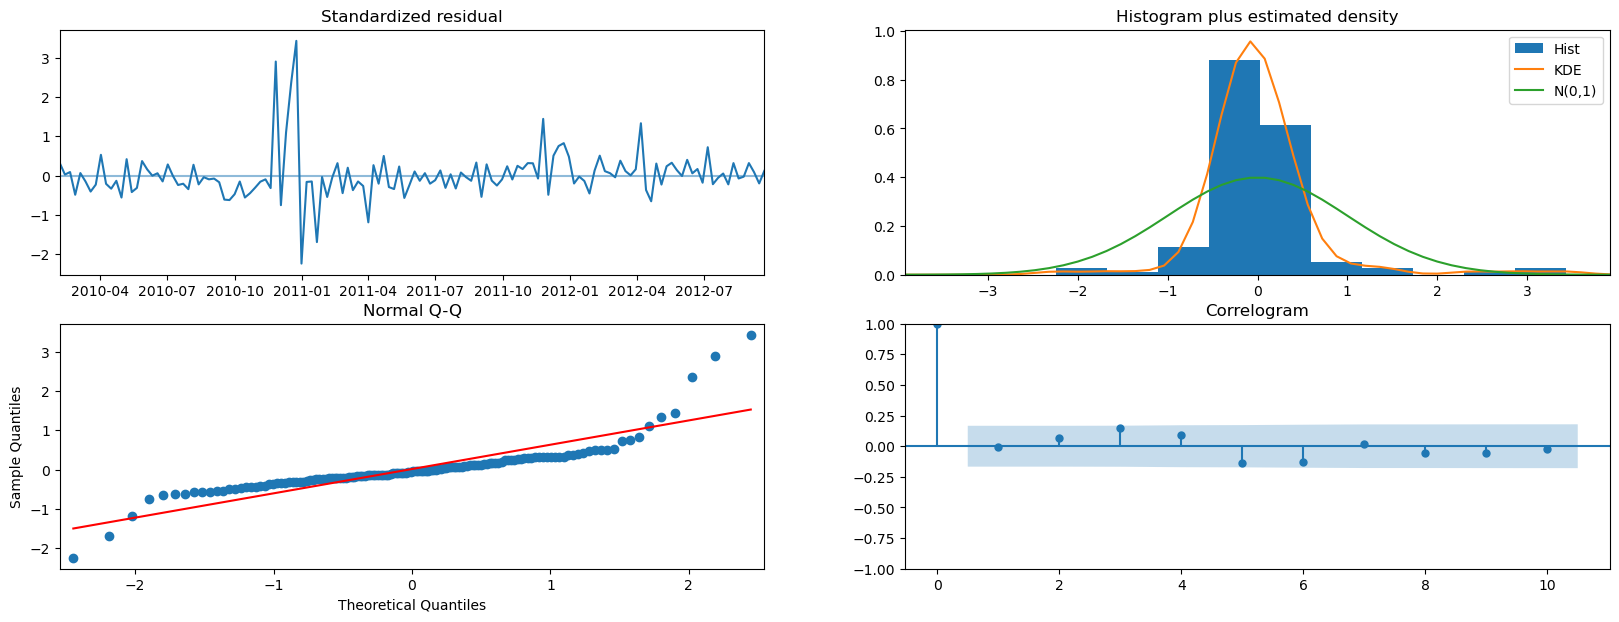

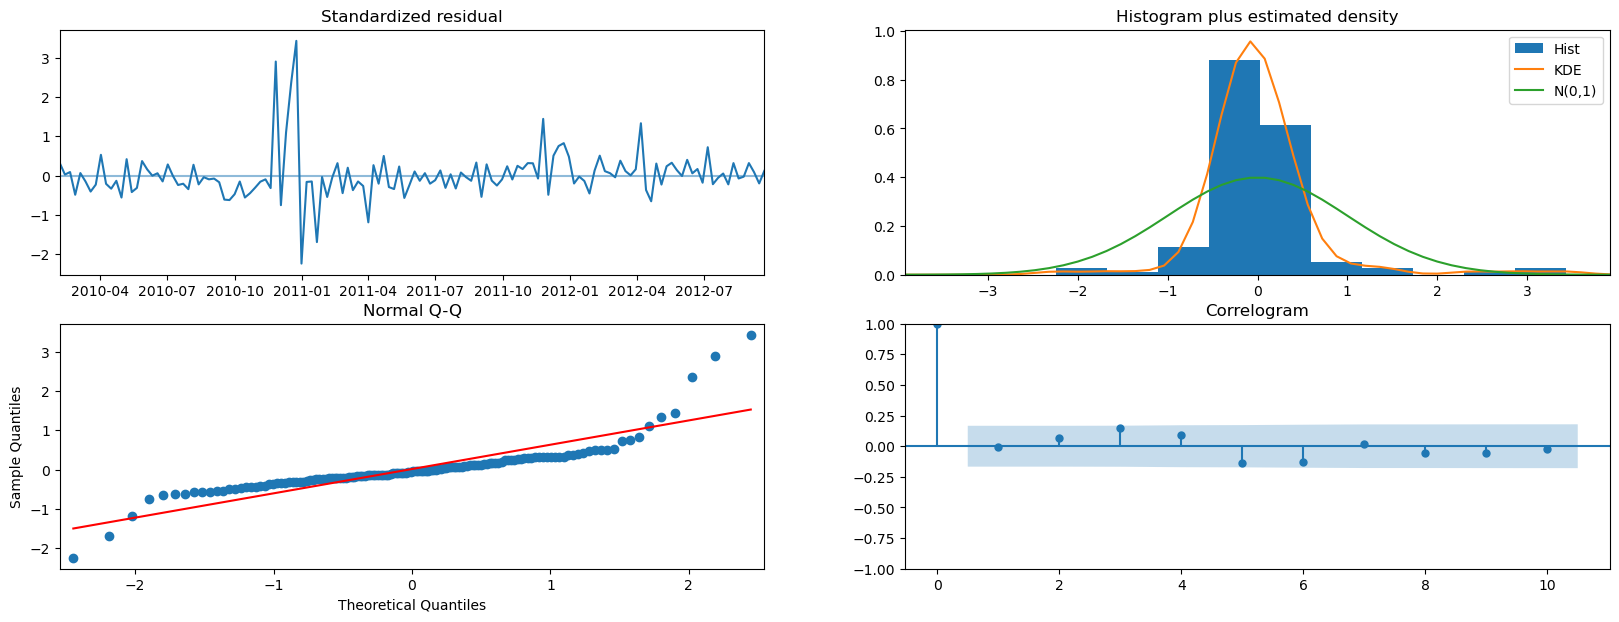

In [24]:
# 모델의 적합성 시각화
auto_arima_model.plot_diagnostics(figsize=(20,7))

# Prophet 시계열 분석

In [26]:
df_prophet= df[['Date2','Weekly_Sales']]
df_prophet

,Date2,Weekly_Sales
0,2010-02-05,24924.50
330761,2010-02-05,5015.30
330762,2010-02-05,62831.98
330763,2010-02-05,10870.40
330764,2010-02-05,345.00
...,...,...
128051,2012-10-26,127416.33
128052,2012-10-26,2820.28
128053,2012-10-26,40228.51
390991,2012-10-26,26750.82


In [27]:
def prepare_data(df, ds, y):
    df = df[[ds, y]]
    df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
    print('The series is ready for use.\n')
    return df

In [28]:
df5 = prepare_data(df_prophet, ds = 'Date2', y = 'Weekly_Sales') 
print(df5.head())
print('')
print('The length of your series is: ', df5.shape[0])

The series is ready for use.

               ds         y
0      2010-02-05  24924.50
330761 2010-02-05   5015.30
330762 2010-02-05  62831.98
330763 2010-02-05  10870.40
330764 2010-02-05    345.00

The length of your series is:  421570


In [29]:
df5['ds']=pd.to_datetime(df5['ds'])

df6=df5.set_index('ds')
df6=df6.resample('W').sum()
df6=df6.reset_index()

# 테스트데이터, 훈련데이터 분할하기
train = df6[:135]
test = df6[135:]

In [30]:
prophet = Prophet(daily_seasonality=False,
                  growth='linear',
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  holidays=None, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05)

prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)

02:19:15 - cmdstanpy - INFO - Chain [1] start processing
02:19:16 - cmdstanpy - INFO - Chain [1] done processing


- daily_seasonality : 일별 패턴 고려 여부
- growth : 시계열 데이터의 성장 모델을 설정(linear로 설정)
- n_changepoints : 변화점의 개수
- changepoint_range : Prophet이 자동으로 선택하는 변화점의 범위(시계열의 뒷부분 80%를 사용).
- yearly_seasonality : 연간 계절성 구성 요소 자동 감지 여부.
- weekly_seasonality : 주간 계절성 구성 요소 자동 감지 여부
- holidays : 공휴일 사용 여부
- seasonality_mode : 계절성 모델을 가법 모델로 설정
- seasonality_prior_scale : 계절성의 강도(높을수록 계절성 많이 반영)
- holidays_prior_scale : 공휴일 효과의 강도
- changepoint_prior_scale : 변화점에 대한 효과의 강도

In [31]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-07,4.722405e+07,4.339824e+07,5.261266e+07,4.722405e+07,4.722405e+07,7.155336e+05,7.155336e+05,7.155336e+05,7.155336e+05,7.155336e+05,7.155336e+05,0.0,0.0,0.0,4.793958e+07
1,2010-02-14,4.721957e+07,4.409519e+07,5.357925e+07,4.721957e+07,4.721957e+07,1.427057e+06,1.427057e+06,1.427057e+06,1.427057e+06,1.427057e+06,1.427057e+06,0.0,0.0,0.0,4.864662e+07
2,2010-02-21,4.721509e+07,4.245568e+07,5.151478e+07,4.721509e+07,4.721509e+07,5.315101e+04,5.315101e+04,5.315101e+04,5.315101e+04,5.315101e+04,5.315101e+04,0.0,0.0,0.0,4.726824e+07
3,2010-02-28,4.721061e+07,4.129148e+07,5.059408e+07,4.721061e+07,4.721061e+07,-1.165190e+06,-1.165190e+06,-1.165190e+06,-1.165190e+06,-1.165190e+06,-1.165190e+06,0.0,0.0,0.0,4.604542e+07
4,2010-03-07,4.720613e+07,4.118455e+07,5.003559e+07,4.720613e+07,4.720613e+07,-1.446608e+06,-1.446608e+06,-1.446608e+06,-1.446608e+06,-1.446608e+06,-1.446608e+06,0.0,0.0,0.0,4.575952e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2012-09-08,4.792593e+07,4.191152e+07,5.133148e+07,4.792593e+07,4.792593e+07,-1.479725e+06,-1.479725e+06,-1.479725e+06,-1.479725e+06,-1.479725e+06,-1.479725e+06,0.0,0.0,0.0,4.644621e+07
141,2012-09-09,4.792741e+07,4.178809e+07,5.086732e+07,4.792741e+07,4.792741e+07,-1.782848e+06,-1.782848e+06,-1.782848e+06,-1.782848e+06,-1.782848e+06,-1.782848e+06,0.0,0.0,0.0,4.614457e+07
142,2012-09-10,4.792890e+07,4.148354e+07,5.031227e+07,4.792890e+07,4.792890e+07,-2.097224e+06,-2.097224e+06,-2.097224e+06,-2.097224e+06,-2.097224e+06,-2.097224e+06,0.0,0.0,0.0,4.583167e+07
143,2012-09-11,4.793038e+07,4.082498e+07,5.003471e+07,4.793036e+07,4.793041e+07,-2.417727e+06,-2.417727e+06,-2.417727e+06,-2.417727e+06,-2.417727e+06,-2.417727e+06,0.0,0.0,0.0,4.551266e+07


Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2010-02-07  4.793958e+07  4.339824e+07  5.261266e+07
1 2010-02-14  4.864662e+07  4.409519e+07  5.357925e+07
2 2010-02-21  4.726824e+07  4.245568e+07  5.151478e+07
3 2010-02-28  4.604542e+07  4.129148e+07  5.059408e+07
4 2010-03-07  4.575952e+07  4.118455e+07  5.003559e+07


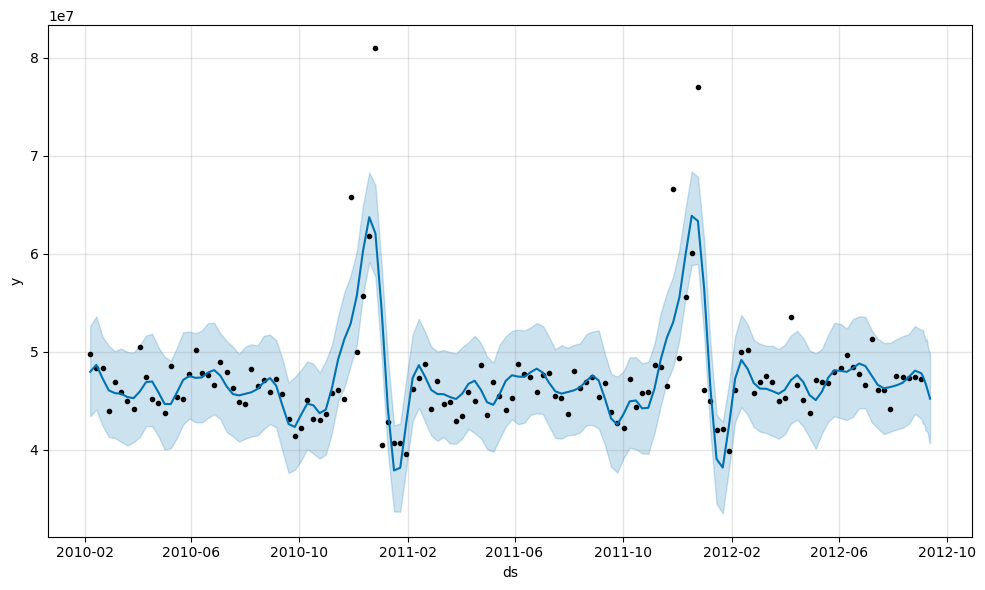

In [32]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [34]:
#y_true .rt\

from sklearn.metrics import mean_absolute_error

print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df6))
print(' ')
y_true= test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  145 135 143
 
Mean Absolute Error: 1426412.444


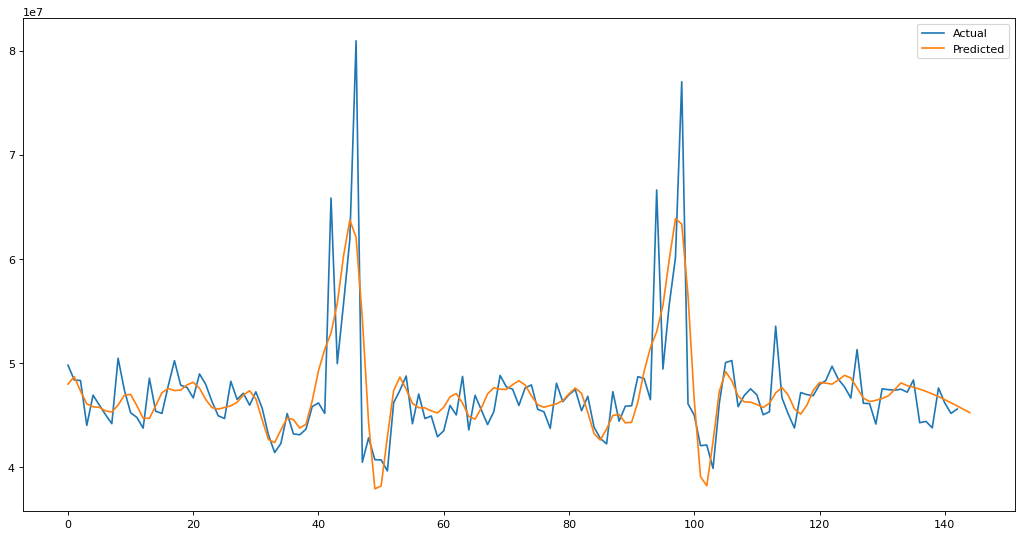

In [35]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

pltt.plot(df6['y'].values, label='Actual')
pltt.plot(forecast['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()

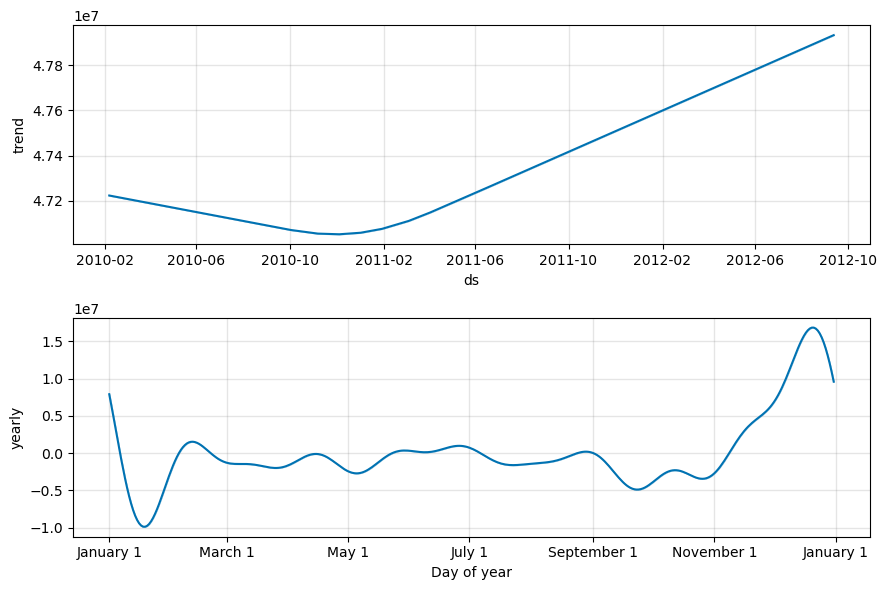

In [36]:
fig2 = prophet.plot_components(forecast)
plt.show()